In [1]:
!pip install bt

In [2]:
!pip install yfinance
!pip install bcdata pandas


In [9]:
import bt
import yfinance as yf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [5]:
def cdi_acumulado(data_inicio, data_fim):
  cdi = consulta_bc(12)
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [6]:
data_inicio = '2015-01-02'
data_fim    = '2019-12-31'


In [15]:
cdi = cdi_acumulado(data_inicio=data_inicio, data_fim=data_fim)


In [16]:
tickers_carteira = ['BOVA11.SA', 'SMAL11.SA']

In [17]:
carteira = yf.download(tickers_carteira, start=data_inicio, end=data_fim)['Close']

[*********************100%***********************]  2 of 2 completed


In [18]:
carteira['renda_fixa'] = cdi
carteira.dropna(inplace=True)

In [ ]:
carteira

,BOVA11.SA,SMAL11.SA,renda_fixa
Date,,,
2015-01-02,47.259998,52.020000,1.000000
2015-01-05,46.320000,50.549999,1.000869
2015-01-06,46.580002,50.000000,1.001304
2015-01-07,48.150002,51.250000,1.001739
2015-01-08,48.509998,52.000000,1.002175
...,...,...,...
2019-12-20,110.839996,133.199997,1.598532
2019-12-23,111.669998,134.580002,1.598805
2019-12-26,112.809998,136.809998,1.599352


In [19]:
rebalanceamento = bt.Strategy('rebalanceamento',
                [bt.algos.RunMonthly(run_on_end_of_period=True),
                 bt.algos.SelectAll(),
                 bt.algos.WeighEqually(),
                 bt.algos.Rebalance()])

In [20]:
buy_hold = bt.Strategy('Buy&Hold',
                   [ bt.algos.RunOnce(),
                     bt.algos.SelectAll(),
                     bt.algos.WeighEqually(),
                     bt.algos.Rebalance()]
                    )

In [21]:
bt1 = bt.Backtest(rebalanceamento, carteira)
bt2 = bt.Backtest(buy_hold, carteira[['BOVA11.SA', 'SMAL11.SA']])

In [22]:
resultados = bt.run(bt1, bt2)

100%|██████████| 2/2 [00:00<00:00,  6.35it/s]


In [23]:
resultados.display()

Stat                 rebalanceamento    Buy&Hold
-------------------  -----------------  ----------
Start                2015-01-01         2015-01-01
End                  2019-12-30         2019-12-30
Risk-free rate       0.00%              0.00%

Total Return         119.97%            148.81%
Daily Sharpe         1.26               1.02
Daily Sortino        2.10               1.69
CAGR                 17.10%             20.02%
Max Drawdown         -21.41%            -34.15%
Calmar Ratio         0.80               0.59

MTD                  6.51%              9.66%
3m                   10.62%             15.58%
6m                   15.94%             22.98%
YTD                  30.15%             43.68%
1Y                   30.15%             43.68%
3Y (ann.)            22.68%             30.26%
5Y (ann.)            17.10%             20.02%
10Y (ann.)           -                  -
Since Incep. (ann.)  17.10%             20.02%

Daily Sharpe         1.26               1.02
Daily Sor

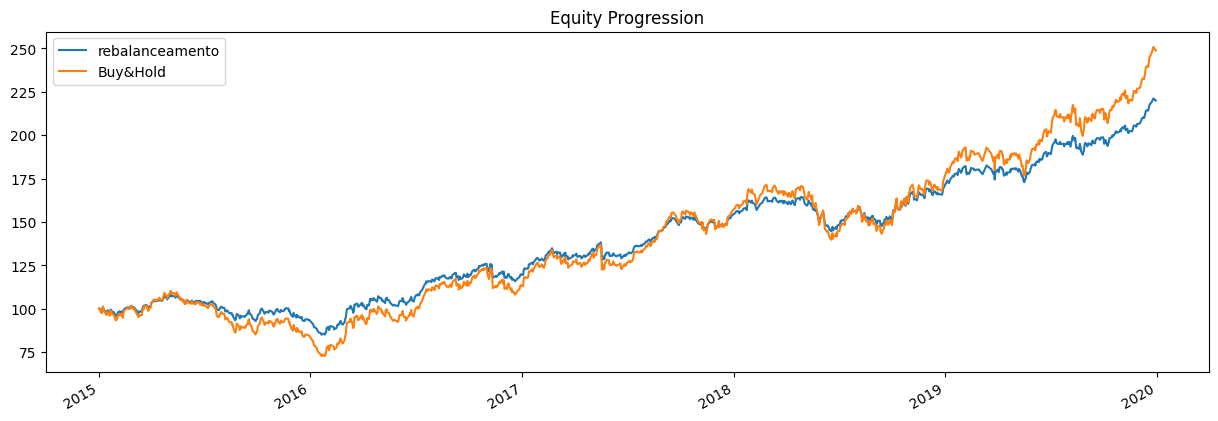

In [24]:
resultados.plot();

In [25]:
resultados.get_transactions()

price  quantity
Date       Security                        
2015-01-02 BOVA11.SA    47.259998    7053.0
           SMAL11.SA    52.020000    6407.0
           renda_fixa    1.000000  333333.0
2015-01-30 BOVA11.SA    45.610001     -52.0
           SMAL11.SA    46.790001     417.0
...                           ...       ...
2019-10-31 SMAL11.SA   115.570000     -43.0
           renda_fixa    1.588157    5141.0
2019-11-29 BOVA11.SA   104.349998      67.0
           SMAL11.SA   121.199997    -153.0
           renda_fixa    1.594198    7323.0

[179 rows x 2 columns]

In [26]:
resultados.get_security_weights()

,BOVA11.SA,SMAL11.SA,renda_fixa
2015-01-01,0.000000,0.000000,0.000000
2015-01-02,0.333325,0.333292,0.333333
2015-01-05,0.331926,0.329059,0.338964
2015-01-06,0.334314,0.325991,0.339645
2015-01-07,0.338950,0.327728,0.333272
...,...,...,...
2019-12-20,0.335706,0.347351,0.316923
2019-12-23,0.336147,0.348799,0.315034
2019-12-26,0.336443,0.351305,0.312232
2019-12-27,0.335036,0.352191,0.312753


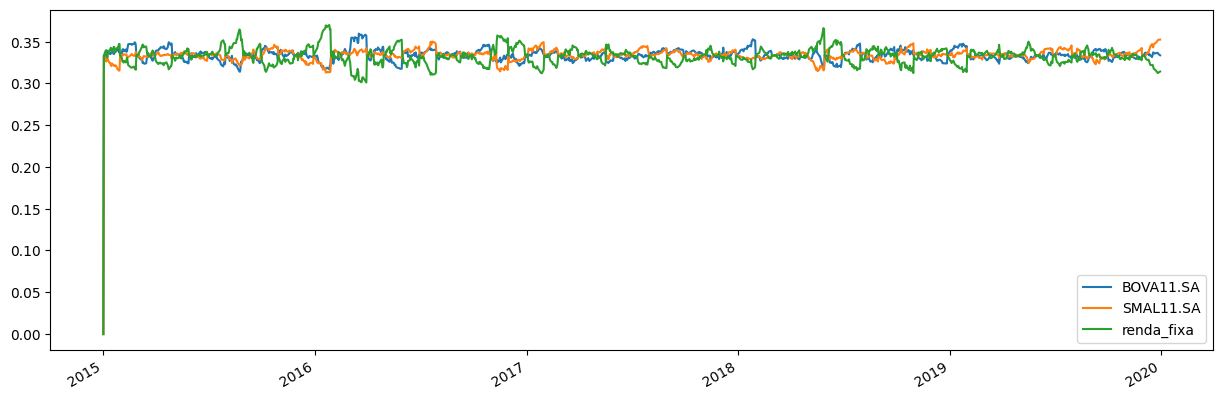

In [27]:
resultados.plot_security_weights()